In [1]:
import os.path

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

sns.set_context("talk")
sns.set_style("white")

In [2]:
from jsuresh_helpers.analyzers.create_sim_map import get_sim_map
from jsuresh_helpers.burnins.run_ssmt_sharon_hack import run_burnin_endpoint_ssmt
from jsuresh_helpers.binning_and_smoothing import fit_lowess_spline
from jsuresh_helpers.analyzers.run_analyzer import run_analyzer_as_ssmt
from jsuresh_helpers.analyzers.sim_endpoint import SimEndpoint

INI File Used: C:\Users\joshsu\Code\malaria-sac-ipt\idmtools.ini


In [3]:
run_analyzer_as_ssmt(experiment_id="b7e98361-9eb6-ec11-a9f6-9440c9be2c51", analyzers=[SimEndpoint], analyzer_args=[{"save_file": "burnin_map.csv"}])


[SLURM]
{
   "type": "COMPS",
   "endpoint": "https://comps.idmod.org",
   "environment": "Calculon",
   "priority": "Highest",
   "simulation_root": "$COMPS_PATH(USER)\\output",
   "num_retries": "0",
   "node_group": "idm_48cores",
   "num_cores": "1",
   "exclusive": "False"
}

The running WorkItem can be viewed at https://comps.idmod.org/#explore/WorkItems?filters=Id=2b9a1e4e-bcb6-ec11-a9f6-9440c9be2c51



Waiting on WorkItem SSMT analysis: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:15<00:00, 15.23s/workitem]

SSMTWorkItem(_uid=UUID('2b9a1e4e-bcb6-ec11-a9f6-9440c9be2c51'), _IItem__pre_creation_hooks=[], _IItem__post_creation_hooks=[], platform_id='b6e7faccdd0d1fb69673a7abedc8ef6d', _platform=<Platform COMPSPlatform - id: b6e7faccdd0d1fb69673a7abedc8ef6d>, parent_id=None, _parent=None, status=<EntityStatus.SUCCEEDED: 'succeeded'>, tags={}, item_type=<ItemType.WORKFLOW_ITEM: 'WorkItem'>, _platform_object={
    "id": "2b9a1e4e-bcb6-ec11-a9f6-9440c9be2c51",
    "name": "SSMT analysis",
    "environment_name": "Calculon",
    "state": "CommissionRequested",
    "tags": {
        "WorkItem_Type": "DockerWorker"
    }
}, _IRunnableEntity__pre_run_hooks=[], _IRunnableEntity__post_run_hooks=[], name='SSMT analysis', assets=AssetCollection(_uid=None, _IItem__pre_creation_hooks=[], _IItem__post_creation_hooks=[], platform_id=None, _platform=None, parent_id=None, _parent=None, status=None, tags={}, item_type=<ItemType.ASSETCOLLECTION: 'Asset Collection'>, _platform_object=None), transient_assets=AssetCo


The running WorkItem can be viewed at https://comps.idmod.org/#explore/WorkItems?filters=Id=bcc12756-bcb6-ec11-a9f6-9440c9be2c51



Waiting on WorkItem Filter outputs for Workitem 2b9a1e4e-bcb6-ec11-a9f6-9440c9be2c51: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:15<00:00, 15.26s/workitem]


In [4]:
df_burnin = pd.read_csv("burnin_map.csv")
df_burnin.drop(columns="task_type", inplace=True)

In [5]:
columns_of_interest = ["aeir",
                       "annual_cases_per_1000",
                       "annual_rdt_prev",
                       "pfemp_frac",
                       "annual_reported_cases_per_1000"]

In [6]:
df_burnin.sort_values(by=["archetype", "habitat_scale", "Run_Number"], inplace=True, ignore_index=True)

df_list = []
for i, sdf in df_burnin.groupby("archetype"):
    for c in columns_of_interest:
        x = sdf["habitat_scale"]
        y = sdf[c]
        xs, ys = fit_lowess_spline(x, y, frac=0.3)

        # Find any negative values and replace them with mean of actual burnin:
        needs_correction = ys < 0
        corrected = np.mean(y[needs_correction])
        ys[needs_correction] = corrected

        sdf[c + "_SMOOTHED"] = ys

    df_list.append(sdf)

df_burnin_with_smoothed = pd.concat(df_list, ignore_index=True)

In [7]:
df_list = []
for i, sdf in df_burnin_with_smoothed.groupby("archetype"):
    archetype = i
    for c in columns_of_interest:
        y = sdf[c]
        ys = sdf[c + "_SMOOTHED"]

        # distance
        d = np.abs(y-ys)**2/ys**2
        sdf[c+ "_DISTANCE"] = d

    for i in range(len(columns_of_interest)):
        if i == 0:
            sdf["TOTAL_DISTANCE"] = sdf[columns_of_interest[i] + "_DISTANCE"]
        else:
            sdf["TOTAL_DISTANCE"] = sdf["TOTAL_DISTANCE"] + sdf[columns_of_interest[i] + "_DISTANCE"]


    # Loop over dataframe (bad?) and find smallest distance burnin for each value of the transmission tag
    dict_list = []
    for i, ssdf in sdf.groupby("habitat_scale"):
        min_dist_row_as_dict = dict(ssdf.loc[ssdf["TOTAL_DISTANCE"].idxmin()])
        dict_list.append(min_dist_row_as_dict.copy())

    min_dist_df = pd.DataFrame(dict_list)

    df_list.append(min_dist_df)

min_dist_full_df = pd.concat(df_list, ignore_index=True)

In [8]:
def plot_burnins(archetype):
    plt.close('all')
    plt.figure(figsize=(8, 8), dpi=200)

    sdf = df_burnin_with_smoothed[df_burnin_with_smoothed["archetype"]==archetype]
    min_dist_this_archetype_df = min_dist_full_df[min_dist_full_df["archetype"]==archetype]
    
    x = sdf["habitat_scale"]
    i = 1
    for c in columns_of_interest:
        y = sdf[c]
        ys = sdf[c + "_SMOOTHED"]

        plt.subplot(3, 2, i)
        plt.scatter(x, y, zorder=0)
        plt.scatter(x, ys, c="C1", zorder=1, marker='.')

        x_selected = min_dist_this_archetype_df["habitat_scale"]
        y_selected = min_dist_this_archetype_df[c]
        plt.scatter(x_selected, y_selected, marker='*', zorder=2, c="C2")

        plt.ylabel(c)
        plt.xlabel("habitat_scale")

        i += 1

    plt.tight_layout()
    plt.show()
    # plt.savefig(f"burnin_endpoints_{archetype}.png")

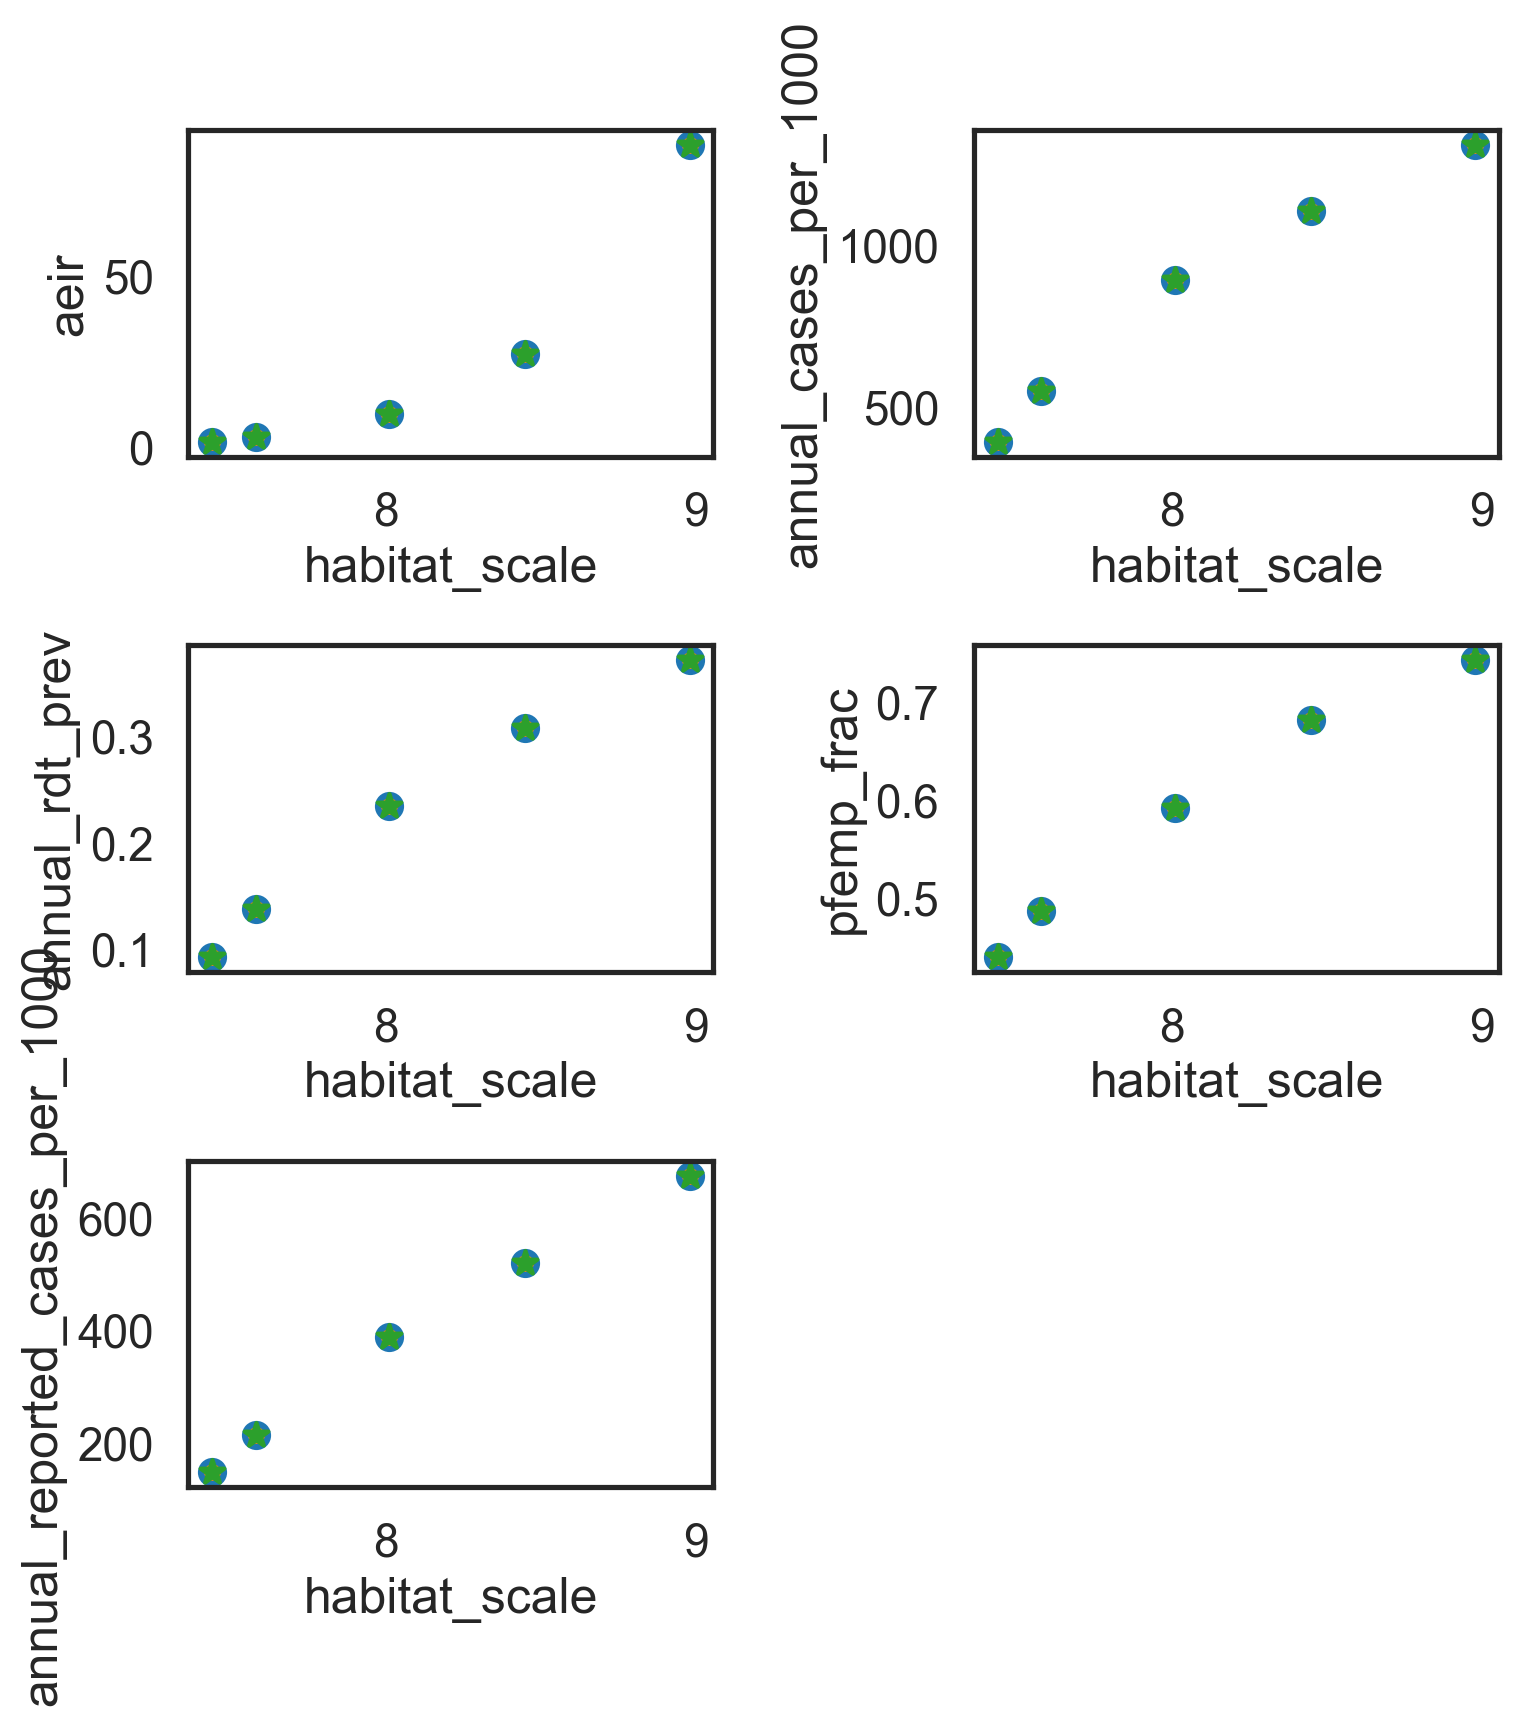

In [9]:
plot_burnins("Central")

In [10]:
for i, sdf in df_burnin_with_smoothed.groupby(["archetype", "habitat_scale"]):
    print(i)
    print(sdf["aeir_SMOOTHED"])

('Central', 7.44)
0    1.587248
Name: aeir_SMOOTHED, dtype: float64
('Central', 7.58)
1    2.881466
Name: aeir_SMOOTHED, dtype: float64
('Central', 8.01)
2    9.558445
Name: aeir_SMOOTHED, dtype: float64
('Central', 8.45)
3    27.354542
Name: aeir_SMOOTHED, dtype: float64
('Central', 8.98)
4    88.380747
Name: aeir_SMOOTHED, dtype: float64
